# Intro:

This notebook is the second in the series for the Capstone Project.  "Capstone_Data-Prep" covers pulling in several
data sources, trimming to the needed observations/variables, joining together, and producing the source data or this
notebook.

In [848]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
import json
import math

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

#sklearn Data Prep:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#sklearn Imputer:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# SkLearn Measurement Libraries:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, mean_squared_error
from sklearn.model_selection import cross_val_score

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_blobs
from sklearn import ensemble


# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [783]:
# Set Paths
path = os.getcwd()
sourceDataPath = path + '\\CleanData\\'
exportPath = path +'\\Export\\'
plotLoc = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/'

# set plot export paths:


print(f"Source Data:",sourceDataPath)
print(f"Exports:",exportPath)
print(f"Plots:",plotLoc)

Source Data: C:\Users\TheCu\OneDrive\Documents\Grad-School-Docs\CapstoneProject\Repo\CleanData\
Exports: C:\Users\TheCu\OneDrive\Documents\Grad-School-Docs\CapstoneProject\Repo\Export\
Plots: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/


# Reusable Functions:

In [784]:
#statRow = []
cleanActionsDF = pd.DataFrame(columns = ['DF','ActionDesc','List-of-Cols','ResultShape'])

def cleanActionsReport (df,df_name,actionDesc, cols):
    # Collect Stats
    row =[]
    actionDesc = actionDesc
    listCols = cols
    resultShape = df.shape
    # Collect Results
    row = [df_name,actionDesc, listCols, resultShape]
    # append stats to Summary Stats DF
    df = cleanActionsDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [785]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per",
                                             "Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [786]:
# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df,scaleList):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in scaleList:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = round(df_std[column],5)
    return df_std

In [787]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [788]:
# Takes a model, and test sets and returns and ROC Curve w/ AUC value

def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    #new section
    #old section
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt

# Source: https://medium.com/@gaurav_bio/making-sense-of-real-world-data-roc-curves-and-when-to-use-them-90a17e6d1db

In [789]:
# Create DF for Capturing Model Results
statRow = []
qe_summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

def OLD_quickModelComparison(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    for model in models:
        # Model Name
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test)
        # summary
        qe_summaryDF = summaryStats(model_name,qe_y_test, y_pred_qe, qe_summaryDF)
        # PLOT ROC curve -- TODO
    return qe_summaryDF

In [790]:
# Create DF for Capturing Model Results
statRow = []
qe_summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1','CM'])

def quickModelComparison(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    for model in models:
        # Model Name
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test)
        # summary
        row =[]
        accuracy = round(accuracy_score(qe_y_test, y_pred_qe),4)
        precision = round(precision_score(qe_y_test, y_pred_qe),4)
        recall = round(recall_score(qe_y_test, y_pred_qe),4)
        f1 = round(f1_score(qe_y_test, y_pred_qe),4)
        cm = confusion_matrix(y_test, y_pred_qe)
        # Collect Results
        row = [model_name,accuracy, precision, recall, f1,cm]
        # append stats to Summary Stats DF
        df = qe_summaryDF
        df_length = len(df)
        df.loc[df_length] = row
    return qe_summaryDF

In [791]:
# Takes a model and various split sets and returns a CM plot w/ Accuracy

def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score

In [792]:
statRow = []
summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1','CM'])

# Takes test and predicted sets and returns precision/recall metrics
def summaryStats (model_name, y_test, y_pred, SummaryDF):
    # Collect Stats
    row =[]
    accuracy = round(accuracy_score(y_test, y_pred),4)
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    cm = confusion_matrix(y_test, y_pred)
    #cm = confusion_matrix(y_test, y_pred)
    #probas = model.predict_proba(roc_x_test) # get the probability distribution
    #fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    #roc_auc = auc(fpr, tpr) # get area under curve
    # Collect Results
    row = [model_name,accuracy,precision, recall, f1,cm]
    # append stats to Summary Stats DF
    df = SummaryDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [793]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model,featureList):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=featureList)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [794]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [795]:
def grid_search_wrapper(refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(x_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

# Get and Prep Data

In [796]:
# Get Source Data
file = 'completeDF.csv'
origDF = pd.read_csv(sourceDataPath+file,skipinitialspace = True)
origDF = origDF.drop(columns=['Unnamed: 0'])
origDF.shape

(348, 167)

In [797]:
nullAnalysisDF = nullAnalysis(origDF)
nullAnalysisDF


Count of Variables: 167
Count of Variables without nulls: 45
Count of Variables with null : 122


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
166,SettlementAmount,348,302,86.782,12,float64
141,xacc_std,348,83,23.851,257,float64
65,esubc_std,348,73,20.977,70,float64
140,xacc,348,50,14.368,284,float64
79,intpn_std,348,49,14.080,276,float64
...,...,...,...,...,...,...
114,pstk,348,1,0.287,49,float64
110,ppegt,348,1,0.287,328,float64
48,dpact,348,1,0.287,326,float64
18,ceq,348,1,0.287,347,float64


In [798]:
# Set aside variables that may be valuable for looks/interpretation of results, but not modeling
orig_lookUps = origDF[['gvkey','tic','curncd','currtr']].copy()

# delete those from origDF
origDF = origDF.drop(columns=['tic','curncd','currtr'])
orig_lookUps.head(3)

,gvkey,tic,curncd,currtr
0,1239,ACV,USD,1.0
1,1266,ALCO,USD,1.0
2,1408,BEAM,USD,1.0


In [799]:
# Scale Data -- Create List for Scaling

## Create list of exceptions for scaling
scaleException = ['gvkey','gsubind','exesign','src','auop','rest_count','rest_count_of_diffs','rest_a_count_of_diffs',
                  'st_per_growth','st_per_currentToMax','st_per_lowToStart','st_volatility','rat_spcsrc',
                  'lawsuit','SettlementAmount',
                  'invch']

## Remove exceptions from scale list
orig_scaleList = origDF.columns.tolist()
for col in scaleException:
    orig_scaleList.remove(col)

# Scale Data -- Call the z_score function
origDF_scaled = z_score(origDF,orig_scaleList)
origDF_scaled.sample(3)



,gvkey,exesign,src,auop,gsubind,aoloch,aoloch_std,at,at_std,bkvlps,...,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,SettlementAmount
278,178317,1,5,2,30202030,-0.05541,-0.39995,-0.33844,-0.38277,-0.07865,...,1.60,-0.12927,-0.1292,-0.29814,-0.22835,0.25476,0.20453,0.0,0.0,NaN
101,13456,1,5,2,30202030,-0.05530,-0.39984,-0.33843,-0.38268,-0.07865,...,1.36,-0.12927,-0.1292,-0.29814,-0.22835,-0.22819,-0.08432,0.0,0.0,NaN
276,177674,1,5,1,30202030,-0.09217,-0.32766,-0.31222,-0.37644,-0.07862,...,0.65,-0.12927,-0.1292,-0.25044,-0.04842,-0.11717,-0.13747,0.0,0.0,NaN


In [800]:
#Imputer 1 - Prep DF for Imputer
## Used as a guide, which states that ExtraTreesRegressor performs best:
## https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505
## Further Documentation: https://scikit-learn.org/stable/modules/impute.html#impute

## Create DF w/o response Vars and a temp to rejoin after imputer runs
completeDF_Imputed = origDF_scaled.copy()
temp_Imputed_Resp = completeDF_Imputed[['gvkey','lawsuit','SettlementAmount']]
completeDF_Imputed = completeDF_Imputed.drop(columns=['lawsuit','SettlementAmount'])
temp_Imputed_Resp.head(3)

,gvkey,lawsuit,SettlementAmount
0,1239,1.0,0.0
1,1266,0.0,NaN
2,1408,0.0,NaN


In [801]:
# Imputer 2 - Run Imputer & Rejoin Temp Data

print("Starting Imputer...")

# Introduce IterativeImputer with an estimator and Fit
imp = IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=10, random_state=42)
imp.fit(completeDF_Imputed)

# Transform the dataset containing missing values
completeDF_Imputed = pd.DataFrame(imp.transform(completeDF_Imputed), columns = completeDF_Imputed.columns)
print("Done w/ Imputer")

# Rejoin Temp - Check Shape, should be 348, 164
completeDF_Imputed = completeDF_Imputed.merge(temp_Imputed_Resp, left_on='gvkey', right_on='gvkey')
completeDF_Imputed.shape

Starting Imputer...
Done w/ Imputer


(348, 164)

In [802]:
# Fix Features That Should be Int w/o decimals
cols = ['gvkey','exesign','src','auop','rat_spcsrc','lawsuit']
completeDF_Imputed[cols] = completeDF_Imputed[cols].astype(int)

# Clean Actions Report -- Drop gsubind (Only kept to inform Imputing)
cleanActionsDesc = "Drop gsubind (Only kept to inform Imputing)."
df_name = "CompleteDF"

colsToDrop = ['gsubind']

completeDF_Imputed = completeDF_Imputed.drop(columns=colsToDrop)
cleanActionsReport(completeDF_Imputed,df_name,cleanActionsDesc,colsToDrop)

completeDF_Imputed.sample(3)

,gvkey,exesign,src,auop,aoloch,aoloch_std,at,at_std,bkvlps,bkvlps_std,...,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,SettlementAmount
12,2663,1,5,1,-0.04735,-0.33497,0.01015,0.10590,-0.07863,-0.07692,...,0.13,-0.12927,-0.1292,0.89842,0.12541,-0.12857,-0.15267,6,0,NaN
122,17934,1,5,1,0.02792,-0.39089,-0.28101,-0.26539,-0.07863,-0.07692,...,0.14,-0.12927,-0.1292,-0.29814,-0.22835,-0.13813,-0.13760,0,0,NaN
46,7798,1,5,1,0.27387,-0.24248,-0.07475,0.38448,11.73266,6.88832,...,0.17,-0.12927,-0.1292,-0.29812,-0.22810,-0.10682,-0.12649,4,0,NaN


In [803]:
# Check Result Nulls
nullAnalysisDF = nullAnalysis(completeDF_Imputed)
nullAnalysisDF


Count of Variables: 163
Count of Variables without nulls: 162
Count of Variables with null : 1


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
162,SettlementAmount,348,302,86.782,12,float64


# LawSuit Modeling

Note to self: In my process, before I ran this section I ran the "Feature Selection" section to trim the
feature list.  That section is archived below, but it made sense to place it below this modeling section
because I did not need to re-run.  The results are saved in the "Export" directory and were used to produce
the feature list at the top of this section.

In [804]:
# Create DF for Capturing Model Results
statRow = []
summaryStatsDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1','CM'])

# Create Lawsuit Modeling DF
ls_Modeling = completeDF_Imputed.copy()
print(ls_Modeling.shape)
ls_Modeling.sample(3)

(348, 163)


,gvkey,exesign,src,auop,aoloch,aoloch_std,at,at_std,bkvlps,bkvlps_std,...,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,SettlementAmount
102,13540,1,5,2,-0.04721,-0.37375,-0.22558,-0.33542,-0.07861,-0.07691,...,0.25,-0.12927,-0.12920,-0.29814,-0.22835,-0.10853,-0.14936,0,0,NaN
225,133367,1,5,1,-0.29026,-0.04270,0.00985,-0.29698,-0.07841,-0.07688,...,0.21,-0.12927,-0.12920,-0.29544,-0.20751,-0.12348,-0.14832,5,0,NaN
298,184339,1,5,2,-0.05536,-0.39895,-0.33807,-0.38121,-0.07865,-0.07692,...,0.92,-0.54056,-0.54049,-0.29814,-0.22835,-0.13991,-0.13898,0,0,NaN


## LawSuit Modeling -- Feature Selection and Prepare Data

Process:
* Check Correlation w/ Response Var
* TODO: Check Collinearity
* Use RF/GB Feature Importance
* Create Resulting Feature List

### LawSuit Modeling -- Feature Selection -- Check Correlation

In [805]:
# Feature Selection -- Check Correlation -- Correlation with output variable
responseVar = 'lawsuit'
cor = round(ls_Modeling.corr(),3)
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
nonRelevant_features = cor_target[cor_target<0.05] # Look for Features w/ less 0.05 cor
nonRelevant_features

exesign              0.044
aoloch_std           0.042
bkvlps               0.035
bkvlps_std           0.037
caps_std             0.016
chech                0.006
ci_std               0.025
cibegni_std          0.033
cshpri_std           0.002
dcpstk               0.016
defrev               0.003
defrev_std           0.024
dvc                  0.040
dvt                  0.039
epsfi                0.026
epsfi_std            0.002
epsfx                0.025
epsfx_std            0.008
epspi                0.026
epspi_std            0.002
esopct               0.000
esopct_std           0.018
esubc                0.022
esubc_std            0.029
fincf_std            0.015
fopo                 0.028
gdwl                 0.029
gdwl_std             0.012
intan                0.026
intan_std            0.002
mii                  0.005
mii_std              0.024
msa                  0.021
msa_std              0.024
ni_std               0.034
nopi_std             0.010
oancf_std            0.039
o

In [806]:
## Feature Selection -- Check Correlation -- Trim DF to Relevant Features

# List of features to drop
nonRelevant_features = nonRelevant_features.index.values.tolist()
# Override
overrideCols = ['st_per_growth','sec_ajpm']
for col in overrideCols:
    nonRelevant_features.remove(col)

# Clean Actions Report -- Remove Featues w/ Low Correlation
cleanActionsDesc = "Drop Features with less than 0.05 corr while making sure to have 1 feature per source"
df_name = "CompleteDF"

ls_Modeling_relFeat = ls_Modeling.drop(columns=nonRelevant_features)
cleanActionsReport(completeDF_Imputed,df_name,cleanActionsDesc,nonRelevant_features)

# Resulting DF
print(ls_Modeling_relFeat.shape)
ls_Modeling_relFeat.sample(3)

(348, 107)


,gvkey,src,auop,aoloch,at,at_std,caps,capx,capx_std,ceq,...,rest_a_count_of_diffs,st_per_growth,st_per_currentToMax,st_volatility,sec_ajpm,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,SettlementAmount
19,3138,5,1,-0.02974,-0.27100,-0.36225,-0.19480,-0.21930,-0.39141,-0.28765,...,1.0,0.36,0.81,0.13,-0.1292,-0.12888,-0.15063,4,0,NaN
154,28844,5,1,-1.19211,0.27795,1.30056,0.31880,0.46377,1.19067,0.62643,...,0.0,0.71,0.63,0.27,-0.1292,-0.12506,-0.14934,0,0,NaN
326,187711,5,1,-0.05808,-0.33807,-0.37741,-0.21789,-0.27979,-0.46256,-0.30384,...,0.0,14.00,0.04,1.45,-0.1292,0.00095,-0.06765,0,1,0.0


### LawSuit Modeling -- Feature Selection -- Check Collinearity

TODO

In [807]:
# Feature Selection -- Check Correlation --- Check for Correlations of Relevant Features Against Each
## Need to identify any collinear features
tempCLCheck = ls_Modeling_relFeat.drop(columns=['lawsuit','gvkey'])
cor = round(tempCLCheck.corr(),3)
cor


,src,auop,aoloch,at,at_std,caps,capx,capx_std,ceq,ceq_std,...,rest_a_sum_diff,rest_a_count_of_diffs,st_per_growth,st_per_currentToMax,st_volatility,sec_ajpm,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,SettlementAmount
src,1.000,0.085,0.135,0.043,0.084,-0.008,0.030,0.058,0.031,0.136,...,-0.027,-0.106,0.003,0.023,0.036,0.007,-0.024,-0.023,-0.099,0.010
auop,0.085,1.000,-0.035,-0.027,0.002,0.051,-0.046,-0.070,-0.025,-0.083,...,0.018,-0.034,-0.036,-0.311,0.203,0.143,-0.068,-0.057,-0.230,-0.064
aoloch,0.135,-0.035,1.000,0.248,0.119,0.091,0.224,0.342,0.208,0.281,...,-0.105,-0.016,-0.007,0.066,-0.009,0.025,-0.004,-0.003,-0.018,0.020
at,0.043,-0.027,0.248,1.000,0.842,0.697,0.911,0.812,0.961,0.649,...,0.142,0.058,-0.021,0.295,-0.205,-0.011,-0.042,-0.049,0.228,-0.097
at_std,0.084,0.002,0.119,0.842,1.000,0.518,0.746,0.777,0.787,0.604,...,0.279,0.055,-0.023,0.278,-0.181,-0.004,-0.027,-0.035,0.184,-0.116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sec_ajpm,0.007,0.143,0.025,-0.011,-0.004,-0.018,0.001,0.015,0.001,0.003,...,-0.017,-0.068,-0.040,-0.156,0.151,1.000,0.032,0.027,-0.070,0.198
sec_trt1m_mean,-0.024,-0.068,-0.004,-0.042,-0.027,-0.028,-0.035,-0.041,-0.038,-0.027,...,-0.014,-0.013,0.086,-0.149,0.180,0.032,1.000,0.993,-0.099,-0.004
sec_trt1m_std,-0.023,-0.057,-0.003,-0.049,-0.035,-0.035,-0.041,-0.050,-0.046,-0.036,...,-0.016,-0.006,0.137,-0.172,0.209,0.027,0.993,1.000,-0.120,0.053
rat_spcsrc,-0.099,-0.230,-0.018,0.228,0.184,0.201,0.219,0.186,0.220,0.064,...,0.065,0.249,-0.045,0.480,-0.369,-0.070,-0.099,-0.120,1.000,0.028


###  LawSuit Modeling -- Feature Selection -- Use Rand Forest/ GradBoost Feature Importance
* Creates a Test/Train Split (Will Resplit from Source After Feature Selection)
* Then uses Random Forest and Grad Boost for Feature Importance
* Results reflected in feature lists for model and stored as reports
and plots in the export directory


In [808]:
# Prepare For Feature Selection
## Feature Selection Will Use Lawsuit - so drop SettlementAmount
ls_Modeling_relFeat = ls_Modeling_relFeat.drop(columns='SettlementAmount')

## Set gvkey as index
ls_Modeling_relFeat.set_index('gvkey')
print(f"Shape:",ls_Modeling_relFeat.shape)
ls_Modeling_relFeat.sample(3)

Shape: (348, 106)


,gvkey,src,auop,aoloch,at,at_std,caps,capx,capx_std,ceq,...,rest_a_sum_diff,rest_a_count_of_diffs,st_per_growth,st_per_currentToMax,st_volatility,sec_ajpm,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit
156,29028,5,1,4.46215,1.06458,1.02946,0.79153,1.29783,4.68224,1.12754,...,-0.11060,0.0,0.99,0.94,0.23,-0.1292,-0.12392,-0.15337,7,0
86,11976,5,1,-0.05486,-0.33720,-0.37894,-0.21729,-0.27845,-0.45057,-0.30227,...,-0.11060,0.0,0.60,0.94,0.14,-0.1292,-0.12504,-0.15099,4,0
50,8336,5,1,-0.05564,-0.33727,-0.38222,-0.21883,-0.27960,-0.46334,-0.30183,...,-0.11048,2.0,0.72,0.89,0.26,-0.1292,-0.12628,-0.14872,4,0


In [809]:
# Set or Reset Test/Train Split
# Params
df=ls_Modeling_relFeat
ResponseVar = 'lawsuit'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)

x_train shape: (278, 105)
x_test shape: (70, 105)


In [810]:
#TODO - check params with .get_params
# maybe add ration and check knn
# Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')


*******************************************************************************
Before Balancing:
x_train shape:  (278, 105)
y_train shape:  (278,)
x_test shape:  (70, 105)
y_test shape:  (70,)

y_train value counts: 0    243
1     35
Name: lawsuit, dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (486, 105)
y_train shape:  (486,)
x_test shape:  (70, 105)
y_test shape:  (70,)

y_train value counts: 1    243
0    243
Name: lawsuit, dtype: int64
*******************************************************************************


## Feature Selection -- Random Forest

In [811]:
print("starting RF")
# Random Forest
## Set and Fit Model
rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=96, min_samples_split=2, max_depth=20,
                            max_features='sqrt',criterion='gini',n_jobs=-1)

rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


start plot


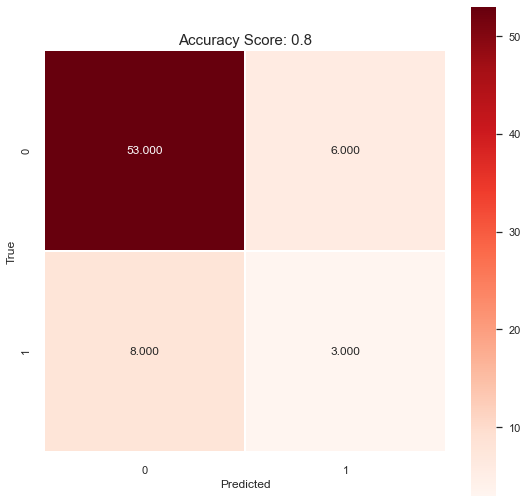

In [812]:
print("start plot")
cm, score = createConfMatrix(rf,y_test, y_pred_rf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM_LS_FeatSelect.png')

In [813]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest-Feature Selection-Tune=Accuracy"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8,0.3333,0.2727,0.3,"[[53, 6], [8, 3]]"


Start RF ROC Plot


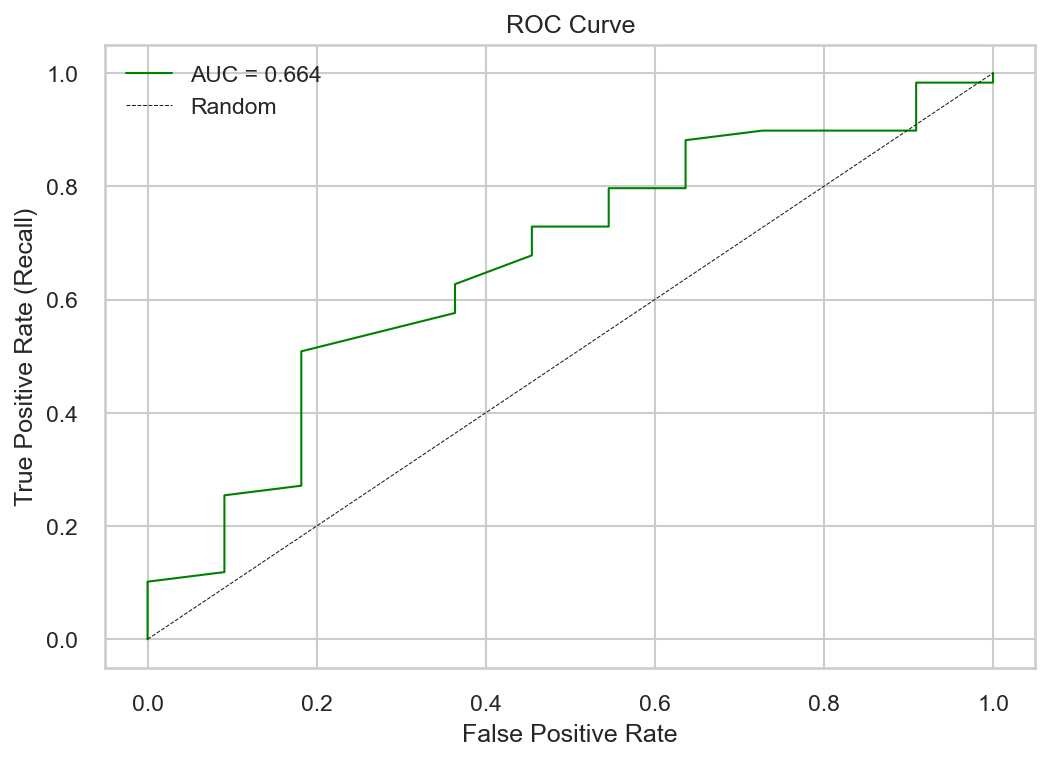

In [814]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test, y_test) # model, x_test, y_test
plt.show()
#plt.savefig(plotLoc+'RF_ROC.png')

Start RF Feature Importance


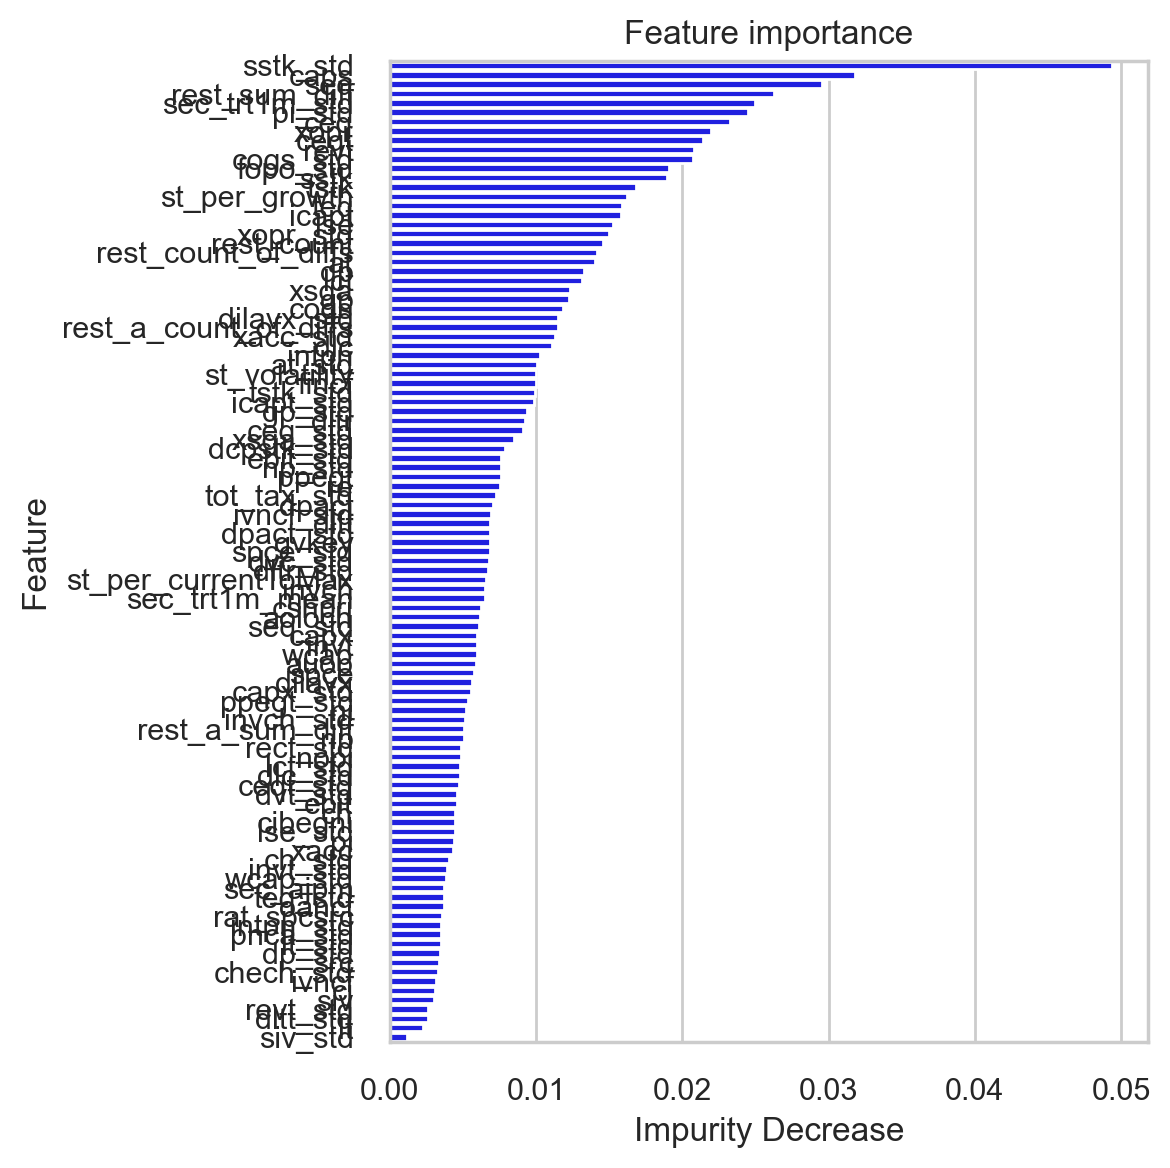

In [815]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_LS_FeatSelect.png')

## Gradient Boosting

In [816]:
print("starting GB")
## Setting when optimized for Accuracy
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,random_state=1,
                                max_depth=10, min_samples_split=75, max_features=8)

gb.fit(x_train,y_train)

## Make Predictions
y_pred_gb = gb.predict(x_test)
print("done predict gb")

starting GB
done predict gb


start gb plot


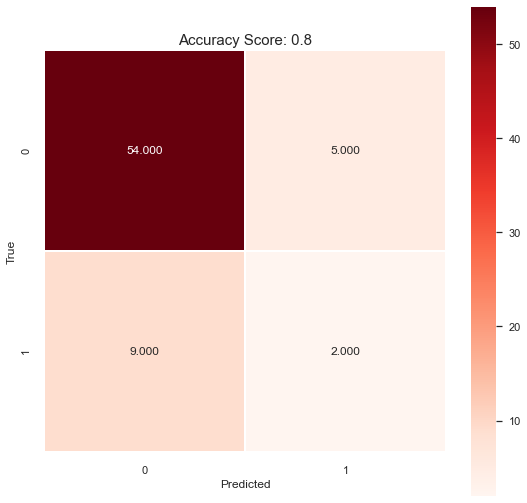

In [817]:
print("start gb plot")
cm, score = createConfMatrix(gb,y_test, y_pred_gb, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'GB_CM_LS_FeatSelect.png')

In [818]:
#  GB -- Precision/Recall Scores

## Set Params
model_name = "Gradient Boost-FeatureSelection-Tune=Accuracy"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_gb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8,0.3333,0.2727,0.3000,"[[53, 6], [8, 3]]"
1,Gradient Boost-FeatureSelection-Tune=Accuracy,0.8,0.2857,0.1818,0.2222,"[[54, 5], [9, 2]]"


Start GB ROC Plot


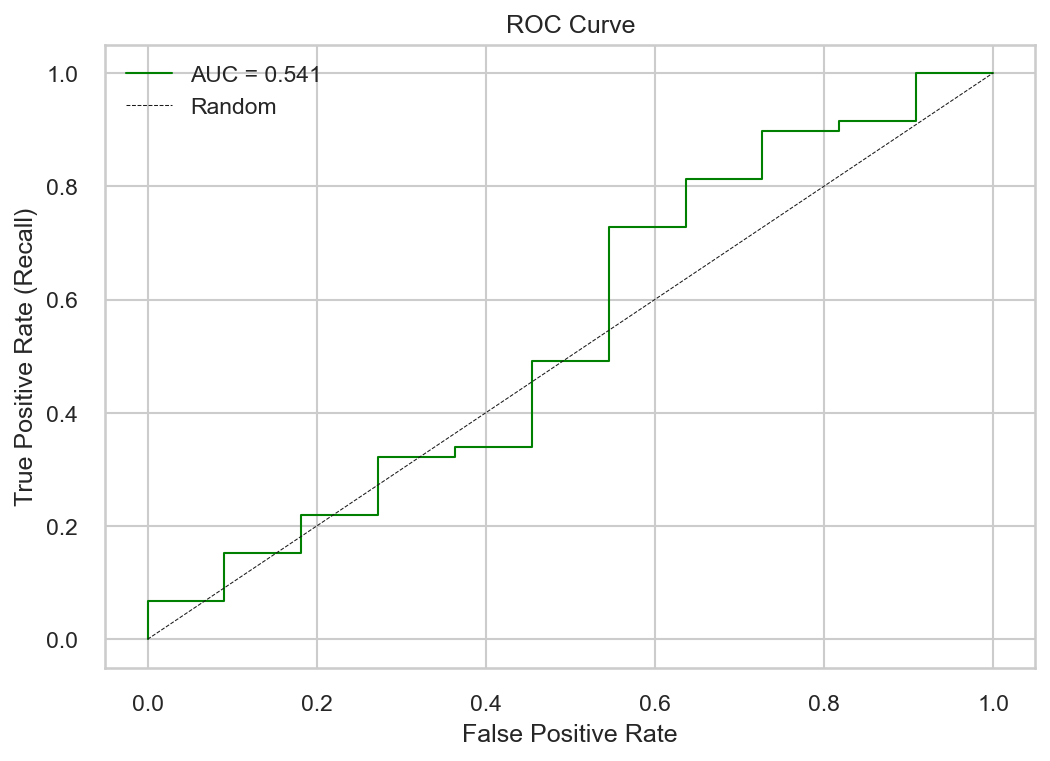

<Figure size 576x396 with 0 Axes>

In [819]:
# ROC Curve/ AUC Score
print("Start GB ROC Plot")

## Call Function
ROC_Curve_Plot(gb,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GB_ROC_LS_FeatSelect.png')

Start GB Feature Importance


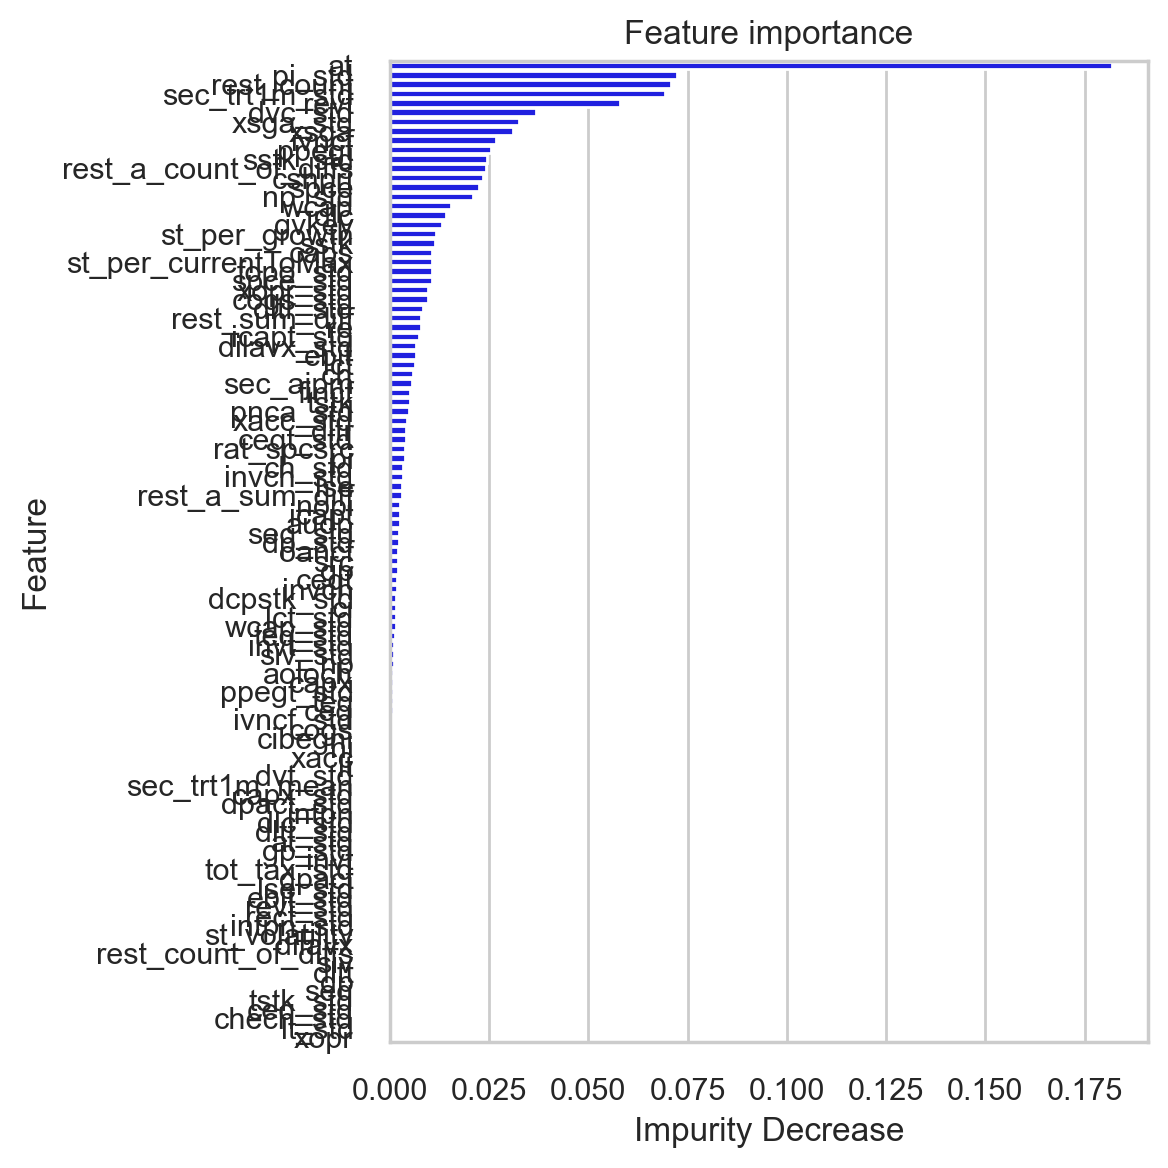

In [820]:
# Gradiant Boost -- Feature Importance -- Plot Most Important Features
print("Start GB Feature Importance")

feature_importances, fig = FeatureImportance(gb,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'GB__LS_FeatSelect.png')

In [821]:
## Combined Feature Importance Plot

rf_importances = rf.feature_importances_
rf_forest_importances = pd.Series(rf_importances, index=featureList)
rf_forest_importances = rf_forest_importances.to_frame().reset_index()
rf_forest_importances = rf_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
rf_forest_importances = rf_forest_importances.sort_values(by='impDecrease',ascending=False)
rf_forest_importances['Model'] = "Random Forest"

gb_importances = gb.feature_importances_
gb_forest_importances = pd.Series(gb_importances, index=featureList)
gb_forest_importances = gb_forest_importances.to_frame().reset_index()
gb_forest_importances = gb_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
gb_forest_importances = gb_forest_importances.sort_values(by='impDecrease',ascending=False)
gb_forest_importances['Model'] = "Gradient Boosting"
feature_importances_comb = rf_forest_importances.append(gb_forest_importances, ignore_index=True)

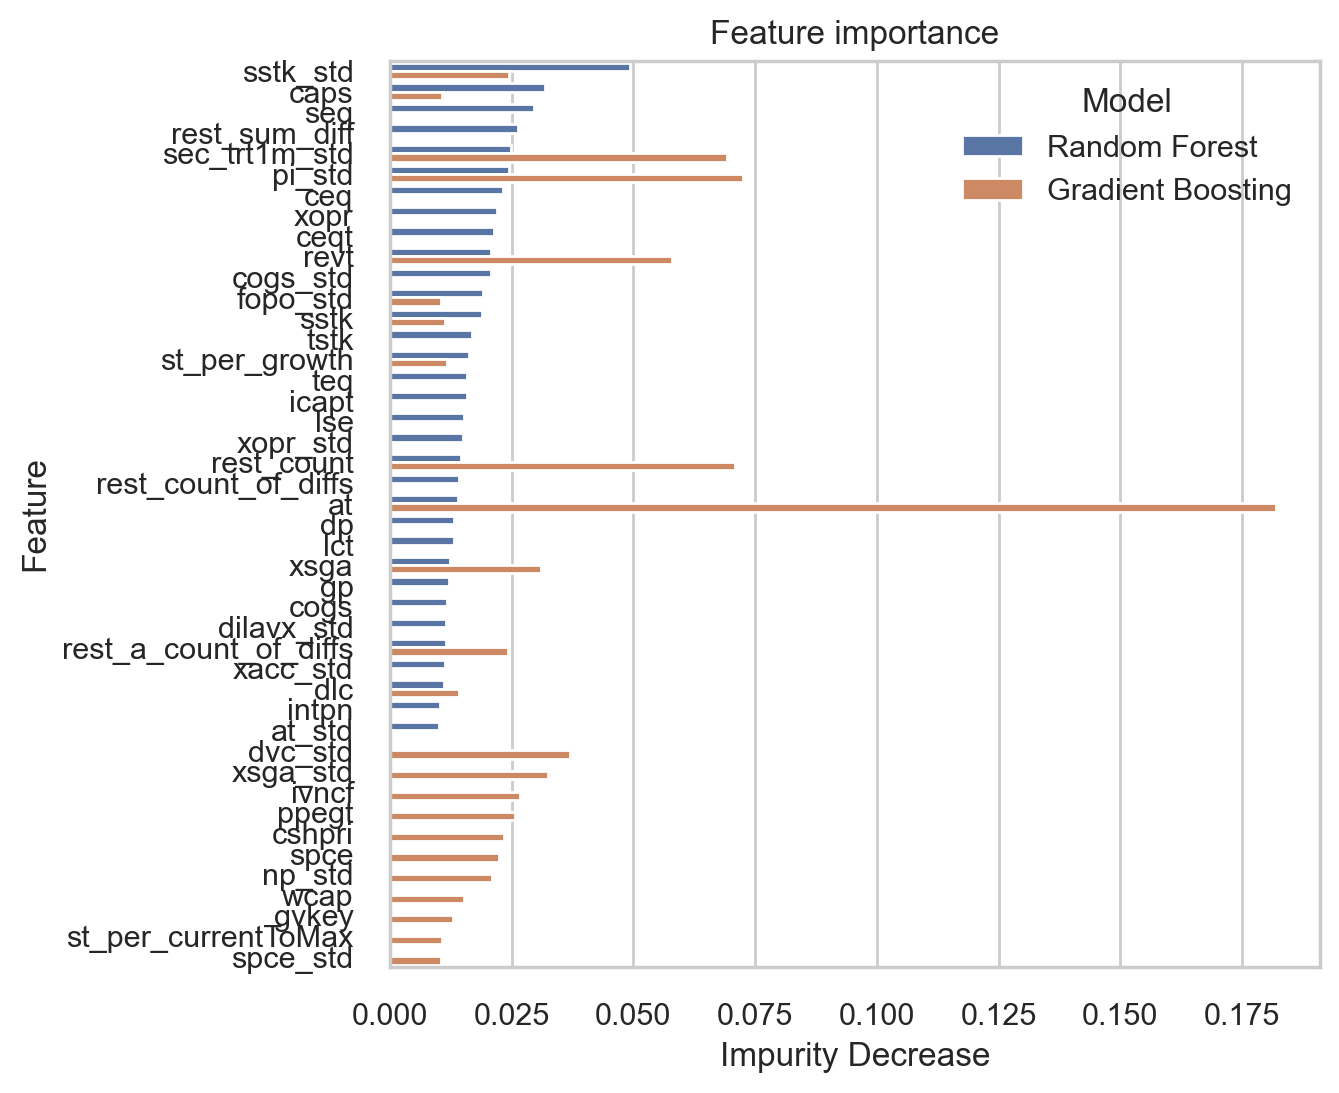

In [822]:
# drop these row indexes
# from dataFrame
index_names = feature_importances_comb[feature_importances_comb['impDecrease'] <= 0.01 ].index

# drop these row indexes
# from dataFrame
feature_importances_comb.drop(index_names, inplace = True)
feature_importances_comb

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature", hue="Model",
                  data=feature_importances_comb)
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc +'Combined_LS_FeatSelect.png')

In [823]:
#TODO: Clean Actions Report.  Not sure how to get the feature names.  Problem is that they can be duplicated.

In [824]:
print(f"feature importance shape:",feature_importances_comb.shape)

featImport_ManAppend = {'feature': 'rat_spcsrc', 'impDecrease': 0.001111, 'Model': 'Manual Addition'}
feature_importances_comb = feature_importances_comb.append(featImport_ManAppend,ignore_index=True)
feature_importances_comb.to_excel(exportPath+"FeatureSelection_LawSuit.xlsx")
feature_importances_comb

feature importance shape: (57, 3)


,feature,impDecrease,Model
0,sstk_std,0.049376,Random Forest
1,caps,0.031814,Random Forest
2,seq,0.029537,Random Forest
3,rest_sum_diff,0.026270,Random Forest
4,sec_trt1m_std,0.024947,Random Forest
5,pi_std,0.024476,Random Forest
6,ceq,0.023269,Random Forest
7,xopr,0.021952,Random Forest
8,ceqt,0.021440,Random Forest
9,revt,0.020789,Random Forest


In [825]:
# Feature Selection -- make list of features
selectedFeatures = feature_importances_comb.copy()
selectedFeatures = selectedFeatures.drop(columns=['impDecrease','Model'])
selectedFeatures = selectedFeatures['feature'].unique()
selectedFeatures



array(['sstk_std', 'caps', 'seq', 'rest_sum_diff', 'sec_trt1m_std',
       'pi_std', 'ceq', 'xopr', 'ceqt', 'revt', 'cogs_std', 'fopo_std',
       'sstk', 'tstk', 'st_per_growth', 'teq', 'icapt', 'lse', 'xopr_std',
       'rest_count', 'rest_count_of_diffs', 'at', 'dp', 'lct', 'xsga',
       'gp', 'cogs', 'dilavx_std', 'rest_a_count_of_diffs', 'xacc_std',
       'dlc', 'intpn', 'at_std', 'dvc_std', 'xsga_std', 'ivncf', 'ppegt',
       'cshpri', 'spce', 'np_std', 'wcap', 'gvkey', 'st_per_currentToMax',
       'spce_std', 'rat_spcsrc'], dtype=object)

In [826]:
# Create Modeling Dataframe for Modeling Lawsuit

## This Feature List is the result of the Feature Importance Analysis.
## 'rat_spcsrc' was manually added so that there was at least one variable from each data source
ls_featList = ['gvkey', 'lawsuit',
               'caps', 'sstk_std', 'sstk', 'teq', 'ceqt', 'rest_sum_diff', 'ceq',
               'at', 'xsga_std', 'st_per_growth', 'rest_count', 'seq', 'pi_std',
               'xacc', 'xsga', 'intpn', 'cogs_std', 'xopr', 'cogs', 'wcap',
               'fopo_std', 'gp_std', 'gp', 'icapt', 'dp', 'sec_trt1m_std', 'revt',
               'dlc', 'tstk_std', 'lse_std', 'dilavx_std', 'ch', 'lse',
               'rest_count_of_diffs', 'aoloch', 'auop', 'dvc_std',
               'sec_trt1m_mean', 'lct_std', 'fincf', 'spce_std', 'st_volatility',
               'dltr', 'rat_spcsrc']

## Create Modeling Dataframe
ls_Modeling = ls_Modeling[ls_featList]
## Set gvkey as index
ls_Modeling = ls_Modeling.set_index('gvkey')
print(ls_Modeling.shape)
ls_Modeling.sample(3)

(348, 45)


,lawsuit,caps,sstk_std,sstk,teq,ceqt,rest_sum_diff,ceq,at,xsga_std,...,aoloch,auop,dvc_std,sec_trt1m_mean,lct_std,fincf,spce_std,st_volatility,dltr,rat_spcsrc
gvkey,,,,,,,,,,,,,,,,,,,,,
30436,0,-0.102765,-0.339700,-0.23847,-0.15222,0.12893,-0.14829,-0.14800,-0.21588,-0.028690,...,-0.070513,1,-0.184080,-0.12956,-0.079240,0.23279,-0.293270,0.21,-0.07729,0
178859,0,-0.218030,1.014871,-0.23194,-0.30640,-0.01320,-0.14824,-0.30418,-0.33834,-0.136281,...,-0.055790,2,0.012364,-0.08134,-0.151202,0.28687,0.030672,1.00,-0.22124,0
137884,0,-0.212450,-0.339660,-0.23847,-0.30948,-0.01630,-0.14792,-0.30628,-0.33839,-0.263460,...,-0.062000,2,-0.300210,-0.09881,-0.370370,0.28617,-0.386570,0.00,-0.22124,2


## LawSuit Modeling -- Modeling

In [827]:
# Set or Reset Test/Train Split
# Params
df=ls_Modeling
ResponseVar = 'lawsuit'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)

x_train shape: (278, 44)
x_test shape: (70, 44)


In [828]:
#TODO - check params with .get_params
# maybe add ration and check knn
# Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')

*******************************************************************************
Before Balancing:
x_train shape:  (278, 44)
y_train shape:  (278,)
x_test shape:  (70, 44)
y_test shape:  (70,)

y_train value counts: 0    243
1     35
Name: lawsuit, dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (486, 44)
y_train shape:  (486,)
x_test shape:  (70, 44)
y_test shape:  (70,)

y_train value counts: 1    243
0    243
Name: lawsuit, dtype: int64
*******************************************************************************


## LawSuit Modeling -- First Model Evaluation

Models to Consider:
* Logistic Regression
* Bagging
* GradBoost
* Random Forests
* KNN
* LDA
* QDA
* Classification Trees
* ADABoost

In [829]:
# Initial Quick Eval

# Set models
logReg_qe = LogisticRegression()
bag_qe =BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0)
gb_qe = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)
rf_qe = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32,n_jobs=-1)
knn_qe = KNeighborsClassifier(n_neighbors=2)
ada_qe = AdaBoostClassifier(n_estimators=100, random_state=0)
lda_qe =LinearDiscriminantAnalysis()
qda_qe = QuadraticDiscriminantAnalysis()
classTree_qe = tree.DecisionTreeClassifier()
gnb_qe = GaussianNB()

# Models List
models = [logReg_qe,bag_qe,gb_qe,rf_qe,knn_qe,ada_qe,lda_qe,qda_qe,classTree_qe,gnb_qe]

## Call Function
qe_summaryDF = quickModelComparison(models,x_train, x_test,
                                    y_train, y_test, qe_summaryDF ) # model list, X sets, y sets, summary df

print("quick evaluation report with vanilla test/train split:")
qe_summaryDF

quick evaluation report with vanilla test/train split:


,Model,Accuracy,Precision,Recall,F1,CM
0,LogisticRegression,0.7000,0.1875,0.2727,0.2222,"[[46, 13], [8, 3]]"
1,BaggingClassifier,0.6857,0.1765,0.2727,0.2143,"[[45, 14], [8, 3]]"
2,GradientBoostingClassifier,0.6714,0.0714,0.0909,0.0800,"[[46, 13], [10, 1]]"
3,RandomForestClassifier,0.7571,0.2000,0.1818,0.1905,"[[51, 8], [9, 2]]"
4,KNeighborsClassifier,0.7286,0.2143,0.2727,0.2400,"[[48, 11], [8, 3]]"
5,AdaBoostClassifier,0.6714,0.1250,0.1818,0.1481,"[[45, 14], [9, 2]]"
6,LinearDiscriminantAnalysis,0.7857,0.3000,0.2727,0.2857,"[[52, 7], [8, 3]]"
7,QuadraticDiscriminantAnalysis,0.8429,0.0000,0.0000,0.0000,"[[59, 0], [11, 0]]"
8,DecisionTreeClassifier,0.6571,0.1579,0.2727,0.2000,"[[43, 16], [8, 3]]"
9,GaussianNB,0.4714,0.1389,0.4545,0.2128,"[[28, 31], [6, 5]]"


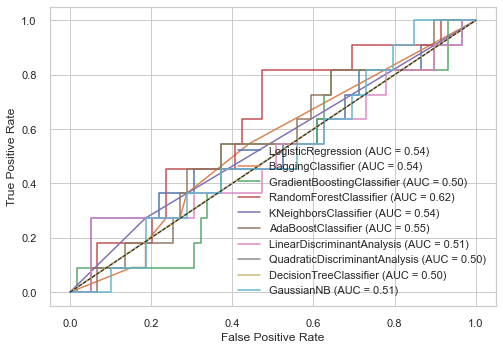

In [830]:
# Quick Eval ROC
# Compare ROC's/AUC's
# Plot First Model:
disp = plot_roc_curve(logReg_qe,x_test,y_test)
# To Add More Models, copy line below and replace model name:
plot_roc_curve(bag_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(gb_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(rf_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(knn_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(ada_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(lda_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(qda_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(classTree_qe,x_test,y_test, ax=disp.ax_)
plot_roc_curve(gnb_qe,x_test,y_test, ax=disp.ax_)
# plot Random Line
plt.plot([0,1], [0,1], '--k', lw=1.0, label='Random')
plt.savefig(plotLoc +'ROC-Compare.png')

## LawSuit Modeling -- Second Model Evaluation
TODO: Tune Models

From the first evaluation, any models that did not make any predictions for the positive response were
eliminted.

In this section, the models were tuned to try and improve the results.  Additionally, a voting classifier
was added that considers all the models.

Remaining Models:
* Random Forests - *Best Accuracy (w/ a negative class prediction)*
* KNN - *Best blend of all metrics (after LDA)*
* LDA - *Best Precision*
* Classification Trees - *Decent Performance - easiest to interpret*
* GaussianNB - *Wildcard: kept for different results, could be useful to voting classifer*
* *NEW:* Voting Classifier

Eliminated Modes:
* Logistic Regression - *Poor overall performance*
* GradBoost - *Poor overall performance - lowest recall/f1*
* Bagging - *Poor overall performance*
* QDA - *Only predicted positive class*

### Lawsuit -- Second Eval -- Random Forest Classifier

In [831]:
print("starting RF")
# Random Forest
## Set and Fit Model
rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=96, min_samples_split=10, max_depth=3,
                            max_features='sqrt',criterion='gini',n_jobs=-1)

rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")


starting RF
done RF


start plot


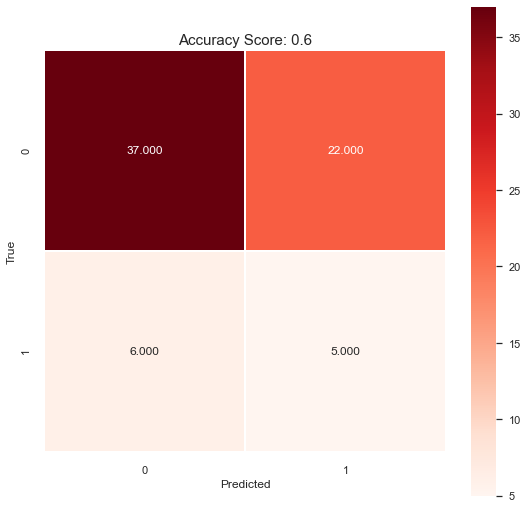

In [832]:
print("start plot")
cm, score = createConfMatrix(rf,y_test, y_pred_rf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM_Lawsuit.png')

In [833]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest -- Second Eval"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8,0.3333,0.2727,0.3000,"[[53, 6], [8, 3]]"
1,Gradient Boost-FeatureSelection-Tune=Accuracy,0.8,0.2857,0.1818,0.2222,"[[54, 5], [9, 2]]"
2,Random Forest,0.6,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"


Start RF ROC Plot


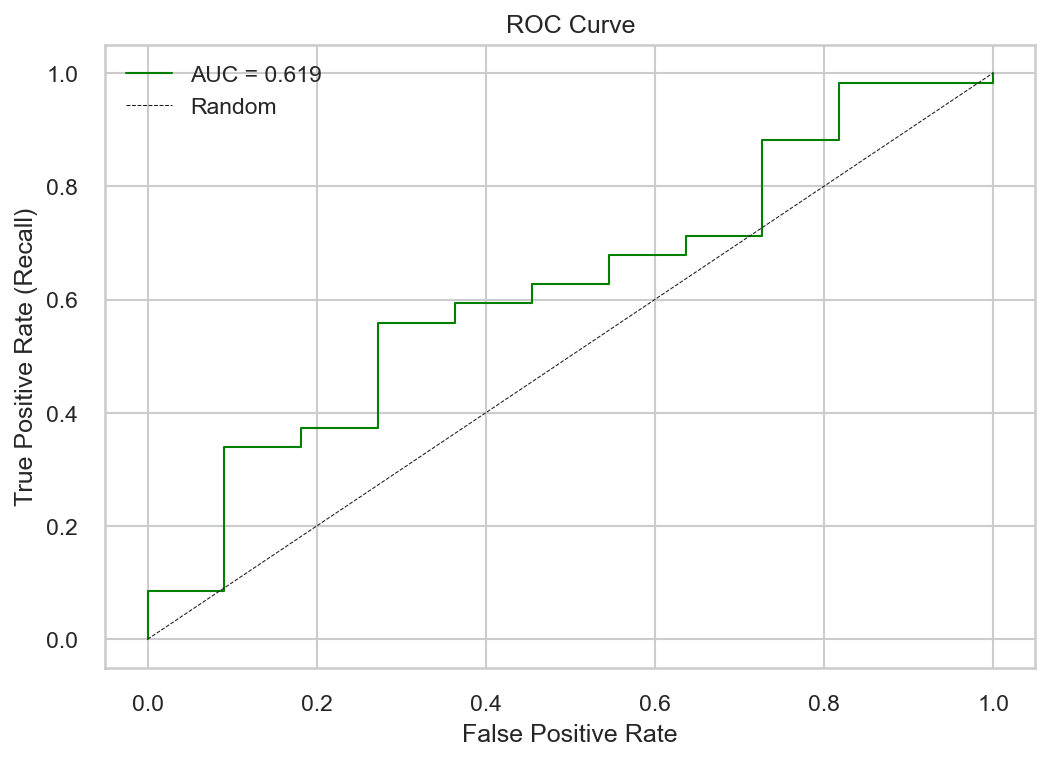

<Figure size 576x396 with 0 Axes>

In [834]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'RF_ROC_Lawsuit.png')

Start RF


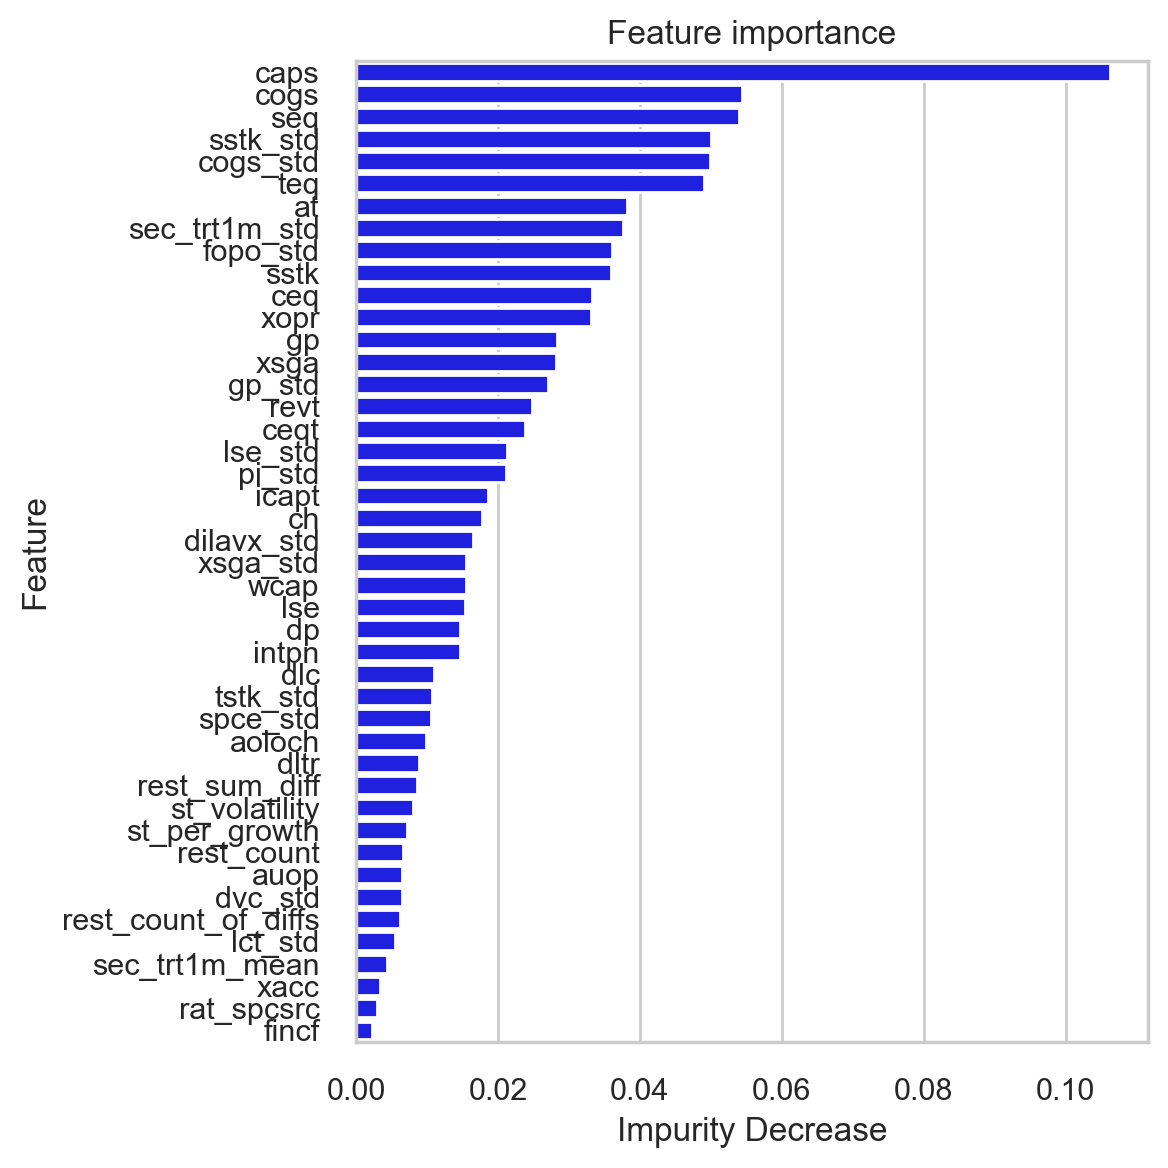

In [835]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Feature-Importance.png')

### Lawsuit -- Second Eval -- KNN

In [849]:
# KNN -- Find Best K-Value
row =[]
knn_bestK = pd.DataFrame(columns = ["k","testScore","MSE","RMSE"])

for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k) # Update Regression object
    knn.fit(x_train, y_train) ## Fit Data
    knn_best_yPred = knn.predict(x_test)
    MSE = round(mean_squared_error(y_test,knn_best_yPred),4)
    RMSE = round(np.sqrt(MSE))
    TestScore = knn.score(x_test, y_test)
    row = [k,TestScore,MSE,RMSE]
    df_length = len(knn_bestK)
    knn_bestK.loc[df_length] = row
knn_bestK

,k,testScore,MSE,RMSE
0,1.0,0.700000,0.3000,1.0
1,2.0,0.728571,0.2714,1.0
2,3.0,0.685714,0.3143,1.0
3,4.0,0.728571,0.2714,1.0
4,5.0,0.642857,0.3571,1.0
5,6.0,0.700000,0.3000,1.0
6,7.0,0.628571,0.3714,1.0
7,8.0,0.671429,0.3286,1.0
8,9.0,0.585714,0.4143,1.0
9,10.0,0.585714,0.4143,1.0


<AxesSubplot:xlabel='k', ylabel='MSE'>

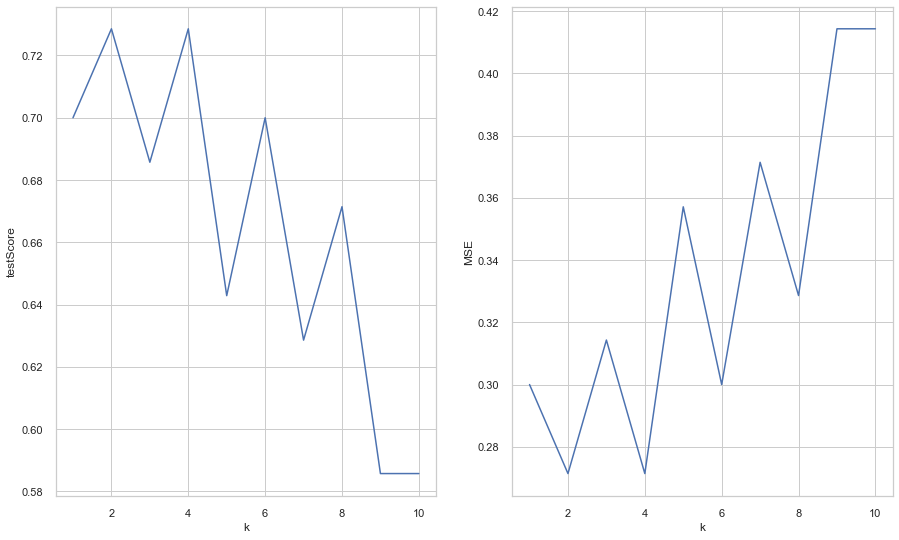

In [851]:
sns.set_style("whitegrid")
fig, (ax1,ax2) = plt.subplots(ncols=2,sharex=True, sharey=False, figsize=(15,9))

sns.lineplot(
    data=knn_bestK, ax=ax1,
    x="k", y="testScore",
    dashes=False)

sns.lineplot(
    data=knn_bestK, ax=ax2,
    x="k", y="MSE",
    dashes=False)

#plt.savefig('Figures/KNN-select-K.png')

In [852]:
# KNN -- Create Regression Object. Fit Data, Make predictions
knn = KNeighborsClassifier(n_neighbors=2) # Update Regression object
knn.fit(x_train, y_train) ## Fit Data
y_pred_knn = knn.predict(x_test)

start plot


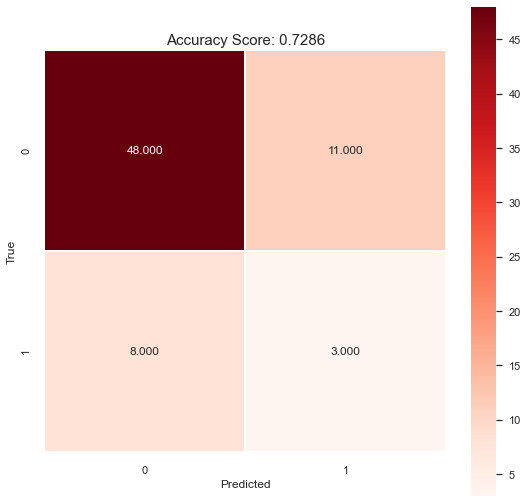

In [853]:
print("start plot")
cm, score = createConfMatrix(knn,y_test, y_pred_knn, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'KNN_CM_Lawsuit.png')

In [855]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "KNN -- Second Eval"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_knn, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8000,0.3333,0.2727,0.3000,"[[53, 6], [8, 3]]"
1,Gradient Boost-FeatureSelection-Tune=Accuracy,0.8000,0.2857,0.1818,0.2222,"[[54, 5], [9, 2]]"
2,Random Forest,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
3,GaussianNB,0.4714,0.1389,0.4545,0.2128,"[[28, 31], [6, 5]]"
4,LDA,0.7857,0.3000,0.2727,0.2857,"[[52, 7], [8, 3]]"
5,KNN -- Second Eval,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
6,KNN -- Second Eval,0.7286,0.2143,0.2727,0.2400,"[[48, 11], [8, 3]]"


Start RF ROC Plot


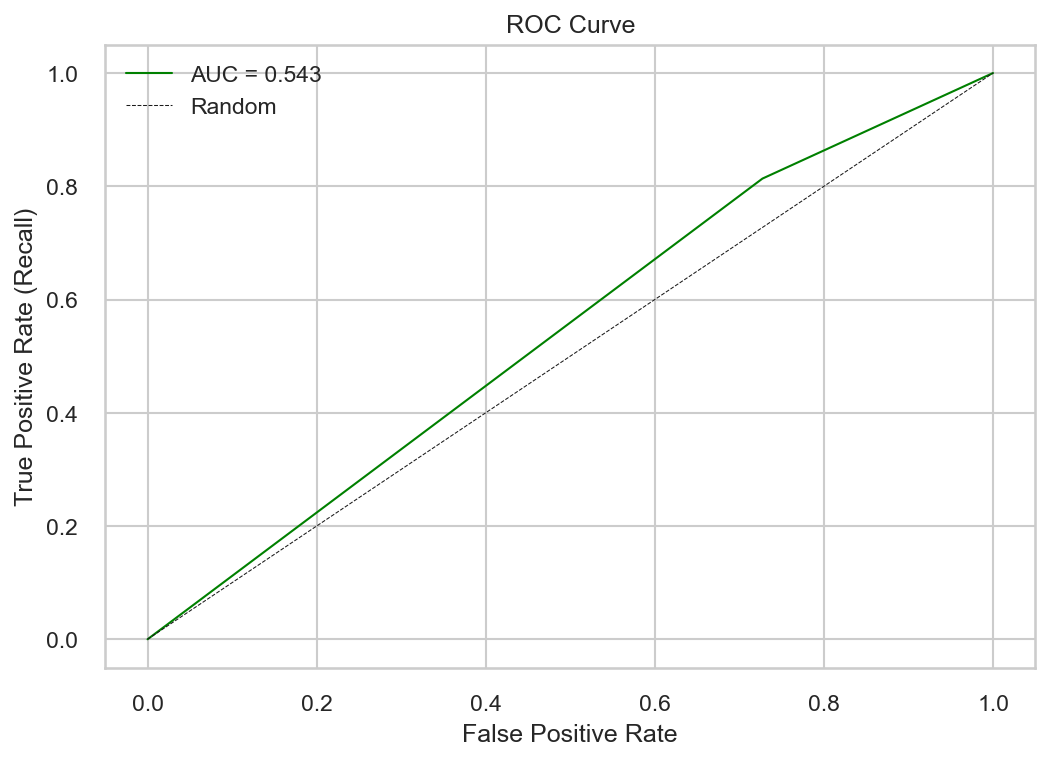

<Figure size 576x396 with 0 Axes>

In [856]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(knn,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'RF_ROC_Lawsuit.png')


### Lawsuit -- Second Eval -- LDA

In [843]:
# LDA -- Create Regression Object. Fit Data, Make predictions
lda = LinearDiscriminantAnalysis()# Update Regression object
lda.fit(x_train, y_train) ## Fit Data
y_pred_lda = lda.predict(x_test)

start plot


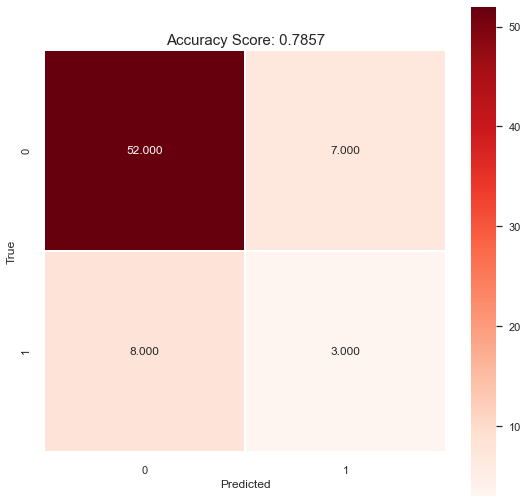

In [844]:
print("start plot")
cm, score = createConfMatrix(lda,y_test, y_pred_lda, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'LDA_CM_Lawsuit.png')

In [845]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "LDA -- Second Eval"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_lda, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8000,0.3333,0.2727,0.3000,"[[53, 6], [8, 3]]"
1,Gradient Boost-FeatureSelection-Tune=Accuracy,0.8000,0.2857,0.1818,0.2222,"[[54, 5], [9, 2]]"
2,Random Forest,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
3,GaussianNB,0.4714,0.1389,0.4545,0.2128,"[[28, 31], [6, 5]]"
4,LDA,0.7857,0.3000,0.2727,0.2857,"[[52, 7], [8, 3]]"


Start LDA ROC Plot


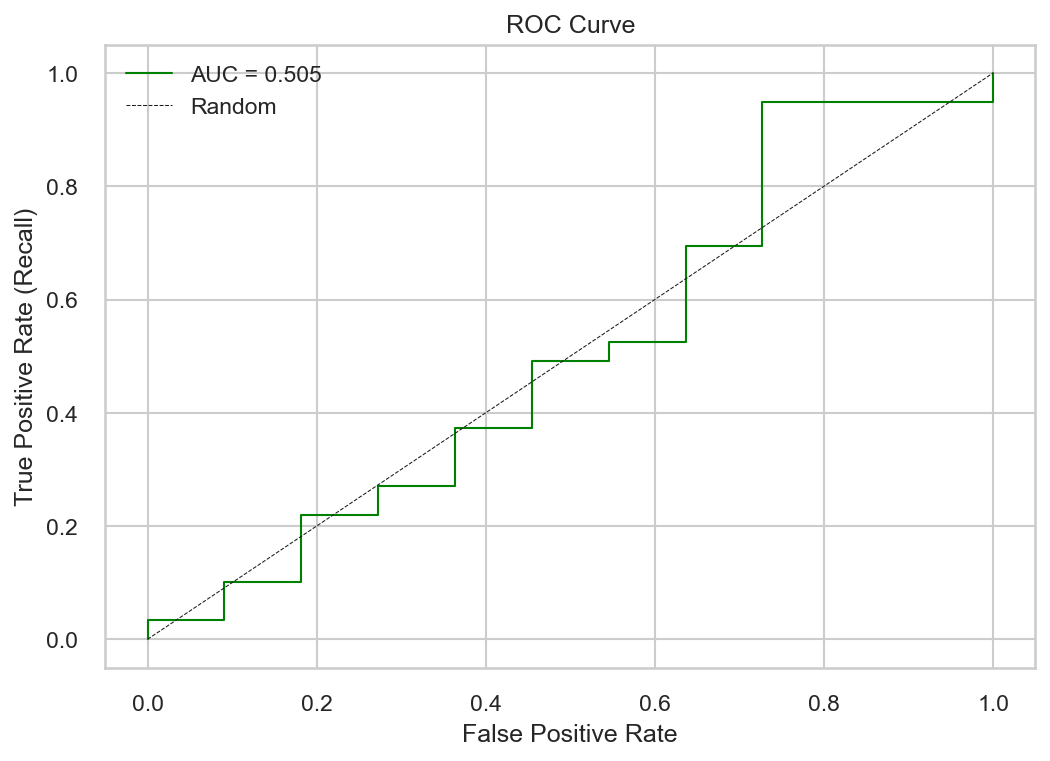

<Figure size 576x396 with 0 Axes>

In [846]:
# ROC Curve/ AUC Score
print("Start LDA ROC Plot")

## Call Function
ROC_Curve_Plot(lda,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'LDA_ROC_Lawsuit.png')

### Lawsuit -- Second Eval --Classification Tree

In [857]:
# DefaultTree -- Set and Train Model
defaultTree = tree.DecisionTreeClassifier()
defaultTree.fit(x_train,y_train).get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [858]:
# DefaultTree--  Get Summary Stats
df = defaultTree

default_training_score = round(accuracy_score(df.predict(x_train),y_train),4)
print(f"Training Score:", default_training_score)

default_test_score = round(accuracy_score(df.predict(x_test),y_test),4)
print(f"Test Score:", default_test_score)

depth = df.get_depth()
print(f"Depth:", depth)

leaves = df.get_n_leaves()
print(f"Terminal Nodes (Leaves):", leaves)

Training Score: 1.0
Test Score: 0.6571
Depth: 14
Terminal Nodes (Leaves): 44


In [859]:
# Best Tree -- Run CV

# Initialize rows and dataframe to store Results
row = []
cv_treeResults = pd.DataFrame(columns = ["depth","scores"])

print ("running CV...")
for x in range (1,30):
    depth = x
    cv_testTree = tree.DecisionTreeClassifier(max_depth=depth)
    # Perform 10-fold cross validation
    scores = cross_val_score(estimator=cv_testTree, X=x_train, y=y_train, cv=10, n_jobs=4)
    row = [depth,scores.mean()]
    df_length = len(cv_treeResults)
    cv_treeResults.loc[df_length] = row
print("best tree:")
print(cv_treeResults[cv_treeResults.scores == cv_treeResults.scores.max()])


running CV...
best tree:
    depth    scores
21   22.0  0.872364


Text(0.5, 0, 'Depth')

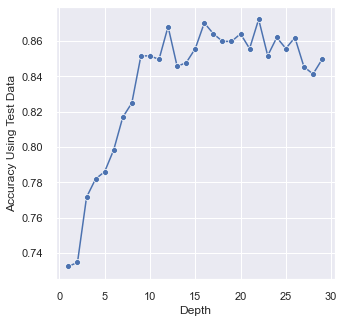

In [860]:
# Best Tree -- Plot CV

sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(5,5)})
fig, ax = plt.subplots()
sns.lineplot(
    data=cv_treeResults,
    x="depth", y="scores",
    marker="o", dashes=False)
ax.set_ylabel("Accuracy Using Test Data")
ax.set_xlabel("Depth")

#plt.savefig('Figures/Best-Tree-Scores.png')

In [861]:
# Best Tree -- Parsimony Principle
## Take the best CV tree and look slightly smaller/larger to find the right balance of accuracy and
## Interprebility

bestTreeDepth = 9
bestTreeRange = 6
minTreeDepth = bestTreeDepth - bestTreeRange
maxTreeDepth = bestTreeDepth +1

row = []
pars_treeResults = pd.DataFrame(columns = ["depth","trainScore","testScore","leaves"])

for x in range (minTreeDepth,maxTreeDepth):
    depth = x
    parsTree = tree.DecisionTreeClassifier(max_depth=depth)
    parsTree.fit(x_train,y_train)
    parsTree_TrainingScore = round(accuracy_score(parsTree.predict(x_train),y_train),4)
    parsTree_TestScore = round(accuracy_score(parsTree.predict(x_test),y_test),4)
    leaves = parsTree.get_n_leaves()
    row = [depth, parsTree_TrainingScore, parsTree_TestScore, leaves ]
    df_length = len(pars_treeResults)
    pars_treeResults.loc[df_length] = row
pars_treeResults

,depth,trainScore,testScore,leaves
0,3.0,0.8313,0.6286,8.0
1,4.0,0.8724,0.7286,12.0
2,5.0,0.9033,0.6857,19.0
3,6.0,0.9259,0.6429,26.0
4,7.0,0.9300,0.6714,30.0
5,8.0,0.9547,0.6286,31.0
6,9.0,0.9630,0.7000,35.0


In [873]:
# Best Tree -- Set and Train Model On Best Model considering principle of parsimony
cv_bestTree = tree.DecisionTreeClassifier(min_samples_split=10,max_depth=4)
cv_bestTree.fit(x_train,y_train)
y_pred_cTree = cv_bestTree.predict(x_test)
print("Done2")

Done2


In [868]:
# Best Tree --  Get Summary Stats
df = cv_bestTree

bestTree_trainingScore = round(accuracy_score(df.predict(x_train),y_train),4)
print(f"Training Score:", bestTree_trainingScore)

bestTree_TestScore = round(accuracy_score(df.predict(x_test),y_test),4)
print(f"Best Tree Test Score:", bestTree_TestScore)

depth = df.get_depth()
print(f"Depth:", depth)

leaves = df.get_n_leaves()
print(f"Terminal Nodes (Leaves):", leaves)

Training Score: 0.8704
Best Tree Test Score: 0.7143
Depth: 4
Terminal Nodes (Leaves): 11


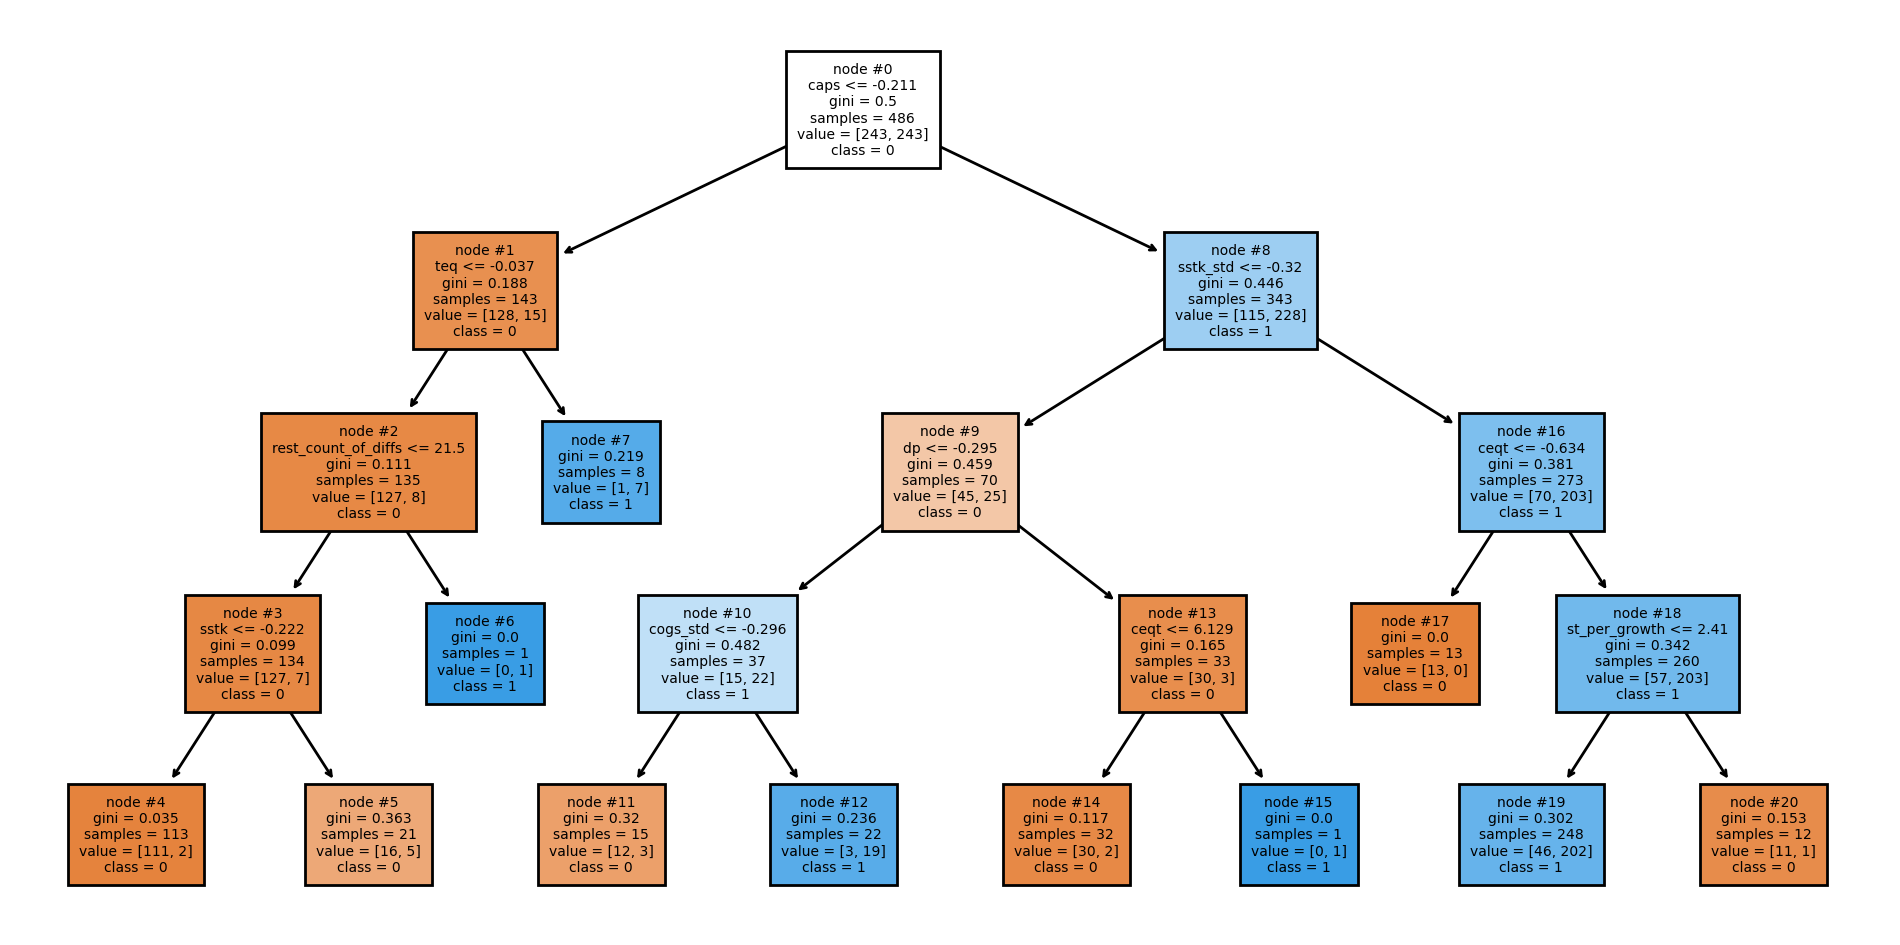

In [869]:
# Best Tree-- Plot Tree
sns.reset_orig()
ResponseVar = 'lawsuit'
PredictorVar = x_train.columns.values.tolist()
cn = ['0','1']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,6), dpi=200)

tree.plot_tree(df,
               feature_names = PredictorVar,
               class_names=cn,
               fontsize=5,
               node_ids=True,
               filled = True);

#plt.savefig('Figures/Best-Tree.png')

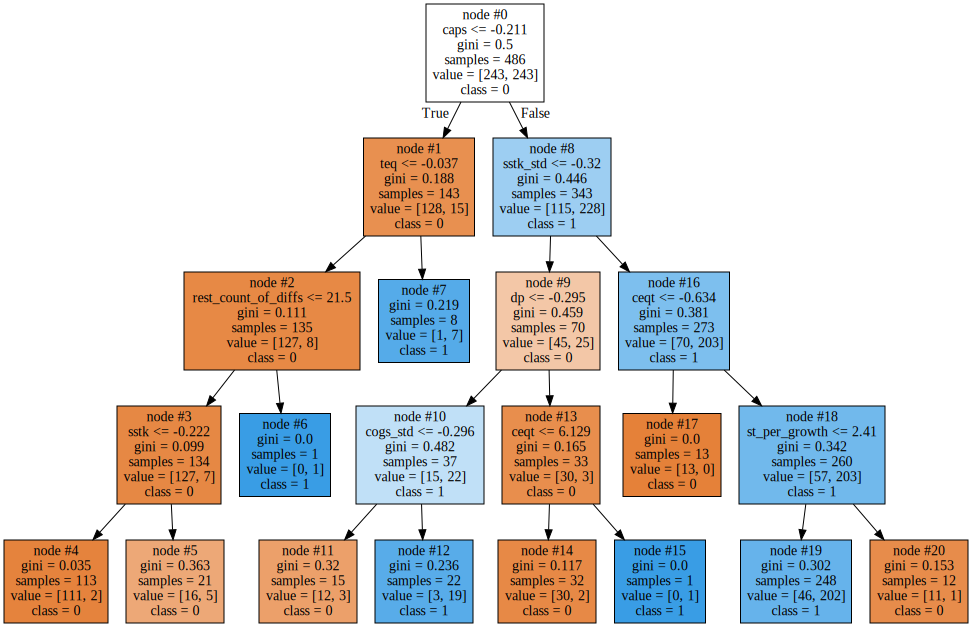

In [870]:
#Plot Best Tree
dot_data = tree.export_graphviz(cv_bestTree, out_file=None,
                                feature_names=PredictorVar,
                                class_names=cn,
                                node_ids =True,
                                #rotate = True,
                                filled=True)


# Draw graph
BM_BestTree = graphviz.Source(dot_data, format="png")
#BM_BestTree.render('Figures/BM_BestTree',view=True)
BM_BestTree

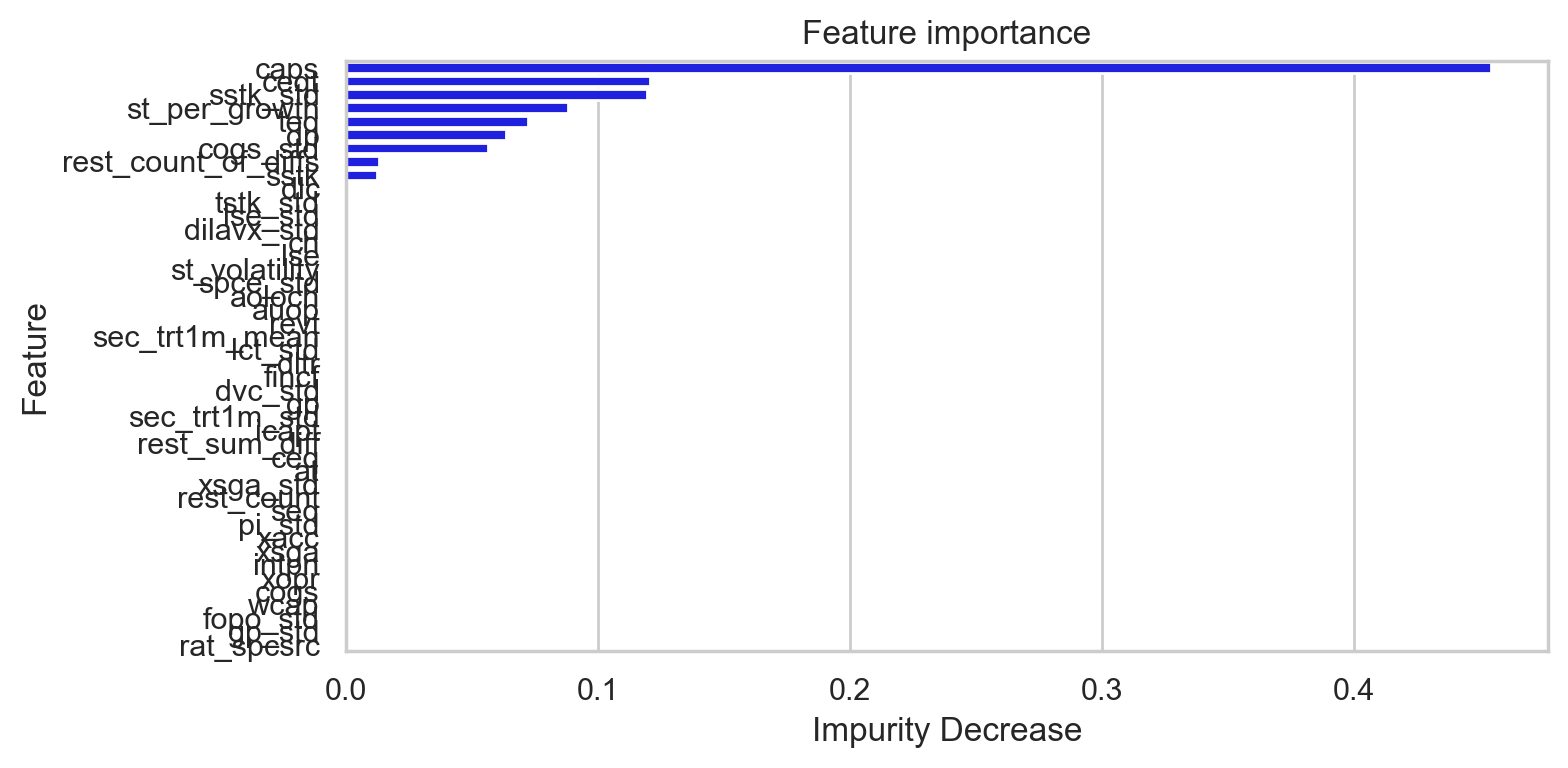

In [872]:
# Best Tree-- Plot Most Important Features
importances = cv_bestTree.feature_importances_

#Convert Array to DF
feature_importances = pd.Series(importances, index=PredictorVar)
feature_importances = feature_importances.to_frame().reset_index()
feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
#std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (8,4), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")
fig.tight_layout()

#plt.savefig('Figures/Best-Tree-Feauture-Importance.png')

start cTree plot


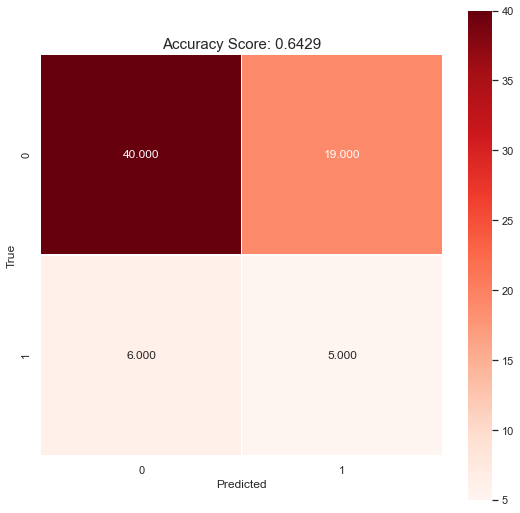

In [877]:
print("start cTree plot")
cm, score = createConfMatrix(cv_bestTree,y_test, y_pred_cTree, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'cTree_CM_Lawsuit.png')

In [875]:
# GNB -- Precision/Recall Scores

## Set Params
model_name = "Classification Tree -- Second Eval"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_cTree, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8000,0.3333,0.2727,0.3000,"[[53, 6], [8, 3]]"
1,Gradient Boost-FeatureSelection-Tune=Accuracy,0.8000,0.2857,0.1818,0.2222,"[[54, 5], [9, 2]]"
2,Random Forest,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
3,GaussianNB,0.4714,0.1389,0.4545,0.2128,"[[28, 31], [6, 5]]"
4,LDA,0.7857,0.3000,0.2727,0.2857,"[[52, 7], [8, 3]]"
5,KNN -- Second Eval,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
6,KNN -- Second Eval,0.7286,0.2143,0.2727,0.2400,"[[48, 11], [8, 3]]"
7,Classification Tree -- Second Eval,0.6429,0.2083,0.4545,0.2857,"[[40, 19], [6, 5]]"


Start GNB ROC Plot


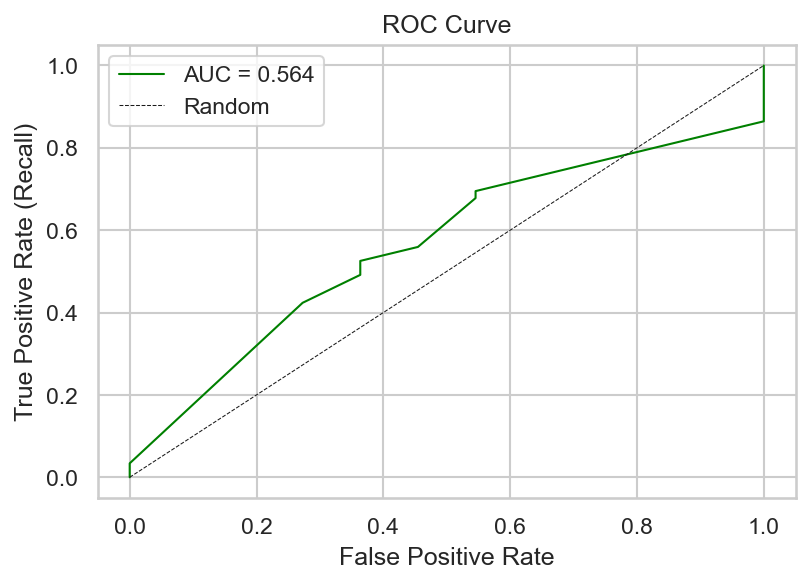

<Figure size 432x288 with 0 Axes>

In [878]:
# ROC Curve/ AUC Score
print("Start GNB ROC Plot")

## Call Function
ROC_Curve_Plot(cv_bestTree,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'cTree_ROC_Lawsuit.png')

### Lawsuit -- Second Eval -- GaussianNB

Note to self: Including this model in case I use Voting Classifier as it may balance out the tendency for
most models to predict 0.

In [836]:
print("starting GaussianNB")
# GaussianNB
## Set and Fit Model
gnb = GaussianNB()
gnb.fit(x_train,y_train)

## Make Predictions
y_pred_gnb = gnb.predict(x_test)
print("done predict gnb")

starting GaussianNB
done predict gnb


start gnb plot


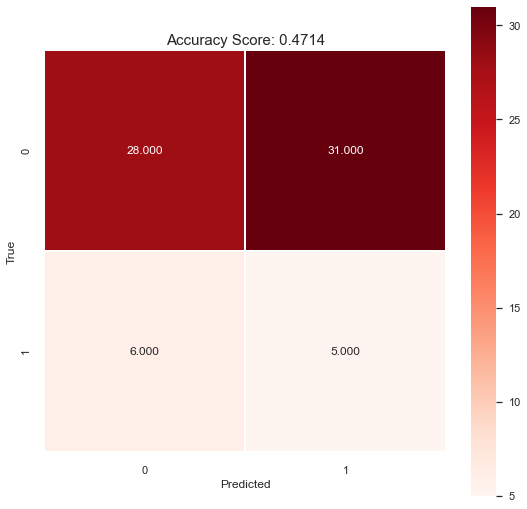

In [837]:
print("start gnb plot")
cm, score = createConfMatrix(gnb,y_test, y_pred_gnb, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'GNB_CM_Lawsuit.png')

In [838]:
# GNB -- Precision/Recall Scores

## Set Params
model_name = "GaussianNB"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_gnb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8000,0.3333,0.2727,0.3000,"[[53, 6], [8, 3]]"
1,Gradient Boost-FeatureSelection-Tune=Accuracy,0.8000,0.2857,0.1818,0.2222,"[[54, 5], [9, 2]]"
2,Random Forest,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
3,GaussianNB,0.4714,0.1389,0.4545,0.2128,"[[28, 31], [6, 5]]"


Start GNB ROC Plot


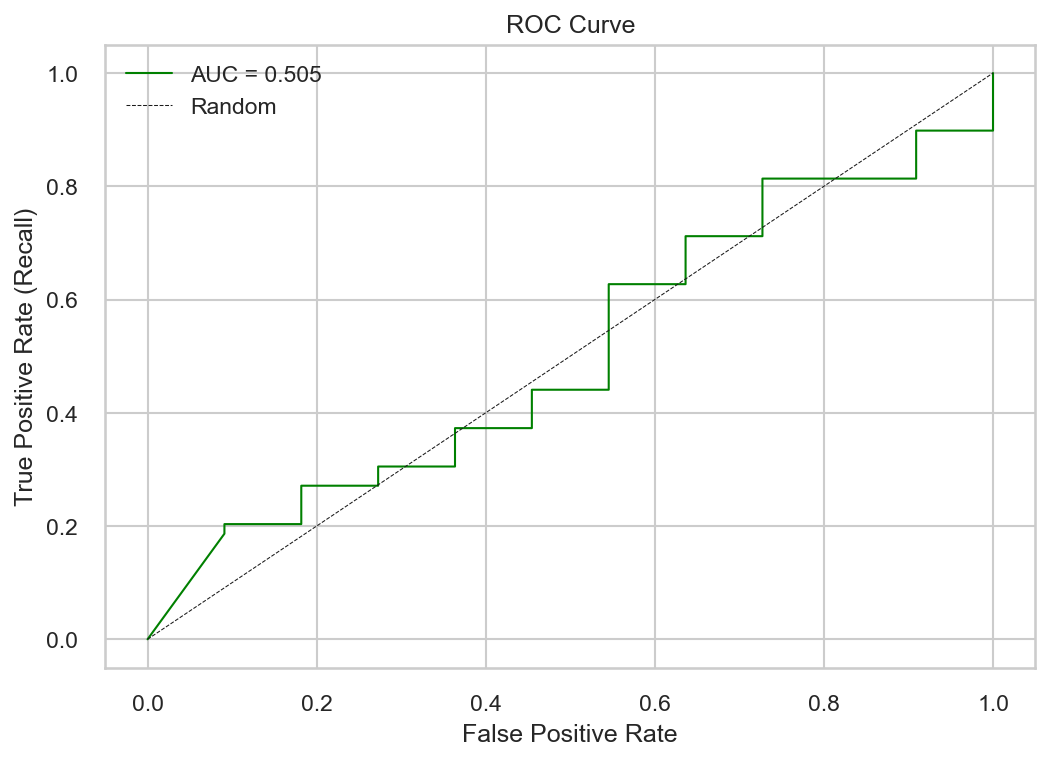

<Figure size 576x396 with 0 Axes>

In [839]:
# ROC Curve/ AUC Score
print("Start GNB ROC Plot")

## Call Function
ROC_Curve_Plot(gnb,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GNB_ROC_Lawsuit.png')

### Lawsuit -- Second Eval -- Voting Classifier

In [880]:
#create a dictionary of our models
estimators=[('RandFor',rf),('KNN',knn),('LDA',lda),('ClassTree',cv_bestTree),('GaussianNB',gnb)] # rf,gnb,gb,nn

#create our voting classifier, inputting our models
eclf = VotingClassifier(estimators,weights=[1,1,1,1,1],voting='soft') #

# fit model to training data
eclf.fit(x_train, y_train)

# Make Predictions
y_pred_eclf = eclf.predict(x_test)
print("done predict eclf")

done predict eclf


start eclf plot


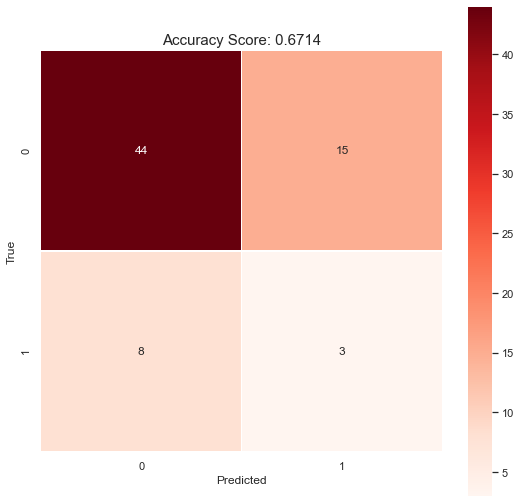

In [881]:
print("start eclf plot")
cm, score = createConfMatrix(eclf,y_test, y_pred_eclf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'eclf_CM.png')

In [882]:
# Random GB -- Precision/Recall Scores

## Set Params
model_name = "Voting Classifier -- Second Eval"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_eclf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1,CM
0,Random Forest-Feature Selection-Tune=Accuracy,0.8000,0.3333,0.2727,0.3000,"[[53, 6], [8, 3]]"
1,Gradient Boost-FeatureSelection-Tune=Accuracy,0.8000,0.2857,0.1818,0.2222,"[[54, 5], [9, 2]]"
2,Random Forest,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
3,GaussianNB,0.4714,0.1389,0.4545,0.2128,"[[28, 31], [6, 5]]"
4,LDA,0.7857,0.3000,0.2727,0.2857,"[[52, 7], [8, 3]]"
5,KNN -- Second Eval,0.6000,0.1852,0.4545,0.2632,"[[37, 22], [6, 5]]"
6,KNN -- Second Eval,0.7286,0.2143,0.2727,0.2400,"[[48, 11], [8, 3]]"
7,Classification Tree -- Second Eval,0.6429,0.2083,0.4545,0.2857,"[[40, 19], [6, 5]]"
8,Voting Classifier -- Second Eval,0.6714,0.1667,0.2727,0.2069,"[[44, 15], [8, 3]]"


Start Ensemble ROC Plot


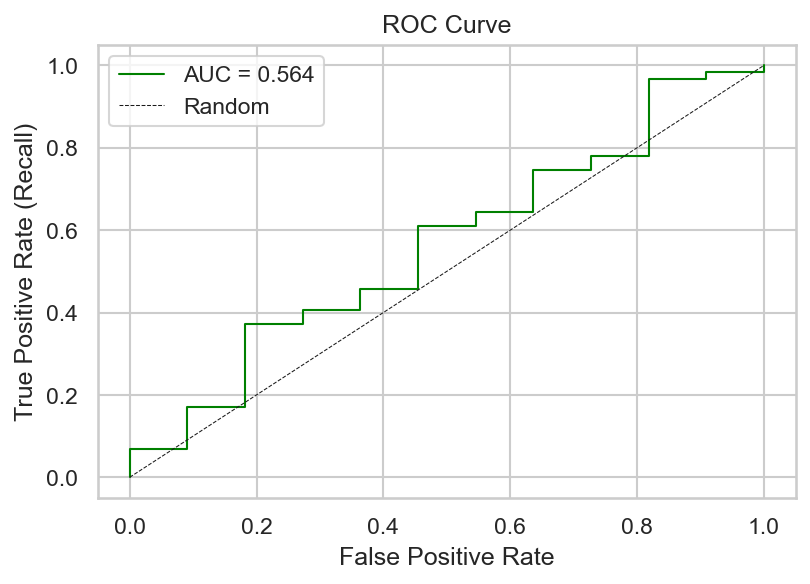

<Figure size 432x288 with 0 Axes>

In [883]:
# ROC Curve/ AUC Score
print("Start Ensemble ROC Plot")

## Call Function
ROC_Curve_Plot(eclf,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'eclf_ROC.png')

## Compare all Models

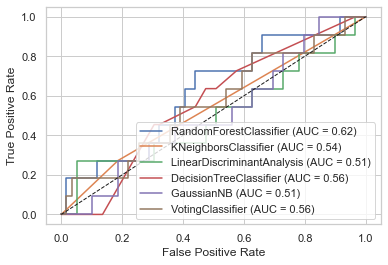

In [885]:
# Compare ROC's/AUC's
# Plot First Model:
disp = plot_roc_curve(rf,x_test,y_test)
# To Add More Models, copy line below and replace model name:
plot_roc_curve(knn,x_test,y_test, ax=disp.ax_)
plot_roc_curve(lda,x_test,y_test, ax=disp.ax_)
plot_roc_curve(cv_bestTree,x_test,y_test, ax=disp.ax_)
plot_roc_curve(gnb,x_test,y_test, ax=disp.ax_)
plot_roc_curve(eclf,x_test,y_test, ax=disp.ax_)
# plot Random Line
plt.plot([0,1], [0,1], '--k', lw=1.0, label='Random')
plt.savefig(plotLoc +'ROC-Compare_Second-Eval.png')

# Exports

In [840]:
# Export Cleaned Data to CSV:

# Export Clean Actions Report:
cleanActionsDF.to_excel(exportPath+"Clean_Actions_Report_Modeling.xlsx")
print("Done")


Done


In [841]:
break

SyntaxError: 'break' outside loop (<ipython-input-841-6aaf1f276005>, line 1)

# Model Tuning

## RF Tuning

In [ ]:
rf.get_params(deep=True)

In [ ]:
clf = RandomForestClassifier(verbose=2)

param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'max_depth': [3,5,10,20],
    'n_estimators': [100,500,1000],
    'max_leaf_nodes':[16,32,64,96],
    'criterion':['gini','entropy']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf

RF_Best_Params = grid_search_clf.best_params_

# Write REport
RF_Best_Params = {'exDict': RF_Best_Params}

with open('RF_Best_Params.txt', 'w') as file:
     file.write(json.dumps(RF_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = rf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

## GB Tuning

In [ ]:
gb.get_params(deep=True)

In [ ]:
clf = GradientBoostingClassifier(verbose=2)

param_grid = {
    'min_samples_split': [10,50,75],
    'n_estimators' : [20,50,100],
    'max_depth': [3,6,10],
    'max_features': [4,8,10],
    'learning_rate':[0.05,0.1,0.2,0.3,0.5,0.99]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
print("ready2")

In [ ]:
print("running2...")
refit_score='recall_score'
grid_search_clf = grid_search_wrapper(refit_score)
grid_search_clf

GB_Best_Params = grid_search_clf.best_params_

print("printing...")

# as requested in comment
GB_Best_Params = {'exDict': GB_Best_Params}

with open('GB_Best_Params_Recall.txt', 'w') as file:
     file.write(json.dumps(GB_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'GB_Decision-Thresh.png')